In [81]:
IMG_DIM = 28
MNIST_PATH = r"/home/anton/KTH/year5/5LSH0/mnist"
EPOCHS = 200
BATCH_SIZE = 500
# LEARNING_RATE = 1e1
LEARNING_RATE = 1e-3
MOMENTUM = 1e-2
WEIGHT_DECAY = 0
CORRUPT_DATA = None
THRESHOLD = 0.04
NOISE_BOUND = 0.06
MODEL_PATH = r"model/adam_simple_ae.pt"

In [82]:
import torch
import torch.nn as nn
from dataloader import DataLoader

In [83]:
class Autoencoder(nn.Module):
    def __init__(self, ):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(IMG_DIM * IMG_DIM, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, IMG_DIM * IMG_DIM),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded)
        return decoded

In [84]:
from torch import optim
model = Autoencoder()
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
)

checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = nn.MSELoss() 


In [85]:
dl = DataLoader()
dl.prepareMNIST(mnist_path=MNIST_PATH, num_train_data=5000, num_normal_data=1000, num_anomaly_data=100, corrupt_train=CORRUPT_DATA, noise_bound=NOISE_BOUND)
train_loader, val_loader, normal_loader, anomaly_loader = dl.getDataLoaderMNIST(batch_size=BATCH_SIZE)


In [86]:

def evaluate_batch(data_loader):
    with torch.no_grad():
        tot_loss = 0
        num_samples = 0
        for _, (images, label) in enumerate(data_loader):
            images = images.reshape(-1, IMG_DIM * IMG_DIM)            
            reconstructed_image = model(images)
            tot_loss += criterion(reconstructed_image, images).item()
            num_samples += images.size(0)
        loss = tot_loss / num_samples
    return images, reconstructed_image, loss

def evaluate_image(data_loader):
    with torch.no_grad():
        out = []
        for _, (images, labels) in enumerate(data_loader):
            for image, label in zip(images, labels):
                image = image.reshape(1, IMG_DIM*IMG_DIM)
                reconstructed_image = model(image)
                loss = criterion(reconstructed_image, image).item()
                out.append((image.numpy(), reconstructed_image.numpy(), loss, label.item()))
    return out

def predict(data_loader, threshold):
    out = evaluate_image(data_loader)
    labels = [element[3] for element in out]
    preds = [int(element[2] < threshold) for element in out]
    return preds, labels

mean loss for normal data: 0.011333090431406163, std: 0.006338145279870628


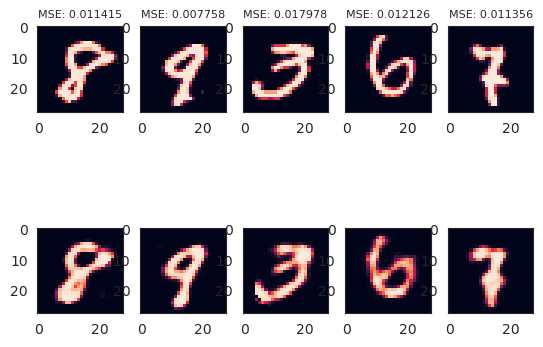

mean loss for anomaly data: 0.03470683228224516, std: 0.009440154544219464


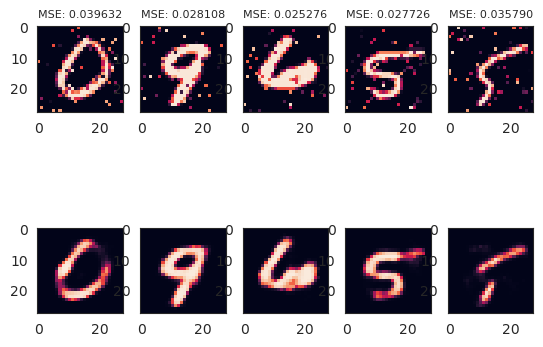

In [87]:
import matplotlib.pyplot as plt
import numpy as np

FIGURE_FONT_SIZE = 8
fig = plt.figure()
normal_out = evaluate_image(normal_loader)
for i in range(1, 6):
        original_image, reconstrucet_image, loss, _ = normal_out[i]
        ax1 = fig.add_subplot(2, 5, i)
        ax1.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(original_image).reshape(IMG_DIM, IMG_DIM))
        ax2 = fig.add_subplot(2, 5, i+5)
        # ax2.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(reconstrucet_image).reshape(IMG_DIM, IMG_DIM))

mean_loss = np.mean([element[2] for element in normal_out])
std_loss = np.std([element[2] for element in normal_out])
print(f"mean loss for normal data: {mean_loss}, std: {std_loss}")

plt.savefig(f"regular_training_normal_reconstruction_MNIST_noise_lvl{'03'}")
plt.show()
plt.close()

fig = plt.figure()
anomaly_out = evaluate_image(anomaly_loader)
for i in range(1, 6):
        original_image, reconstrucet_image, loss, _ = anomaly_out[i]
        ax1 = fig.add_subplot(2, 5, i)
        ax1.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(original_image).reshape(IMG_DIM, IMG_DIM))
        ax2 = fig.add_subplot(2, 5, i+5)
        # ax2.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(reconstrucet_image).reshape(IMG_DIM, IMG_DIM))

mean_loss = np.mean([element[2] for element in anomaly_out])
std_loss = np.std([element[2] for element in anomaly_out])

print(f"mean loss for anomaly data: {mean_loss}, std: {std_loss}")

plt.savefig(f"regular_training_anomaly_reconstruction_MNIST_noise_lvl{'03'}")
plt.show()
plt.close()

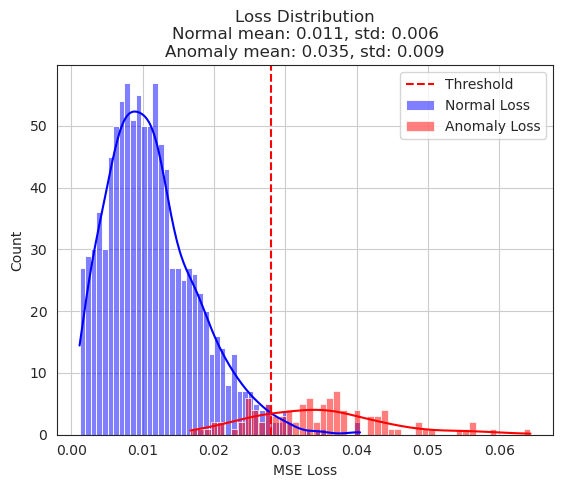

In [110]:
import seaborn as sns
import pandas as pd
normal_loss = np.array([out[2] for out in normal_out])
normal_mean = normal_loss.mean()
normal_std = normal_loss.std()

anomaly_loss = np.array([out[2] for out in anomaly_out])
anomaly_mean = anomaly_loss.mean()
anomaly_std = anomaly_loss.std()


normal_df = pd.DataFrame(
    {
        "Normal Loss": normal_loss,
    }
)
anomaly_df = pd.DataFrame(
    {
        "Anomaly Loss": anomaly_loss
    }
)
normal_df
fig = plt.figure()
sns.set_style("white")
plt.grid()
plt.title(f"Loss Distribution\nNormal mean: {normal_mean:.3f}, std: {normal_std:.3f}\nAnomaly mean: {anomaly_mean:.3f}, std: {anomaly_std:.3f}")
sns.histplot(normal_df["Normal Loss"], kde=True, label="Normal Loss",color ='blue', bins = 50)
sns.histplot(anomaly_df["Anomaly Loss"], kde=True, label="Anomaly Loss",color ='red', bins = 50)
plt.xlabel("MSE Loss")
plt.legend()
plt.savefig(r"plots/simple_ae/loss_distribution")


THRESHOLD = normal_mean + abs(normal_mean - anomaly_mean) / 2
THRESHOLD = 0.028
plt.axvline(x=THRESHOLD, color='red', linestyle='--', label="Threshold")
plt.legend()
plt.savefig(r"plots/simple_ae/threshold_loss_distribution")

plt.show()
plt.close()

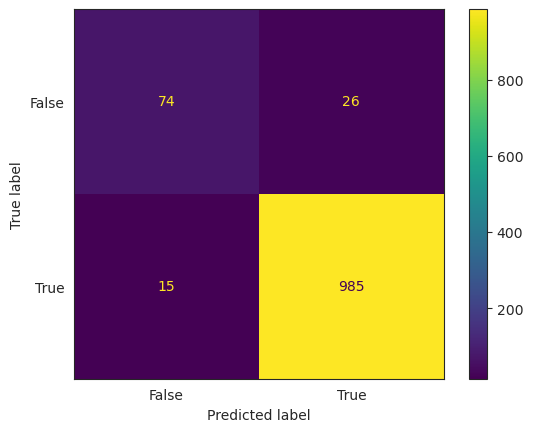

In [112]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

preds, labels = predict(val_loader, threshold=THRESHOLD)

confusion_matrix = metrics.confusion_matrix(labels, preds)

normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1).reshape(2, 1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True]) 
cm_display.plot()
plt.savefig(r"/home/anton/KTH/year5/5LSH0/Anomaly Detection with Autoencoder/plots/simple_ae/" + "confusion_matrix")
plt.show() 
plt.close()

In [113]:
from sklearn.metrics import roc_auc_score
import pandas as pd
metrics_dict = {}
metrics_dict["TN"] = confusion_matrix[0][0]
metrics_dict["FN"] = confusion_matrix[1][0] 
metrics_dict["TP"] = confusion_matrix[1][1]
metrics_dict["FP"] = confusion_matrix[0][1]

metrics_dict["precision"] = precision_score(labels, preds)
metrics_dict["recall"] = recall_score(labels, preds)
metrics_dict["f1"] = f1_score(labels, preds)
metrics_dict["auc"] = roc_auc_score(labels, preds)
metrics_dict["false alarm rate"] = metrics_dict["FP"] / (metrics_dict["FN"] + metrics_dict["TN"])
df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Score'])
df

,Metric,Score
0,TN,74.000000
1,FN,15.000000
2,TP,985.000000
3,FP,26.000000
4,precision,0.974283
5,recall,0.985000
6,f1,0.979612
7,roc,0.862500
8,false alarm rate,0.292135


In [92]:

# print(df.to_latex(index=False, multicolumn=True, column_format="l|r|c"))  

,Metric,Score
0,TN,100.000000
1,FN,416.000000
2,TP,584.000000
3,FP,0.000000
4,precision,1.000000
5,recall,0.584000
6,f1,0.737374
7,roc,0.792000
8,false alarm rate,0.000000
